# **K-means clustering from scratch**

Group movies into clusters that share similar characteristics (like genre, director, rating, etc.), which could be useful for targeted marketing, recommendations, or understanding movie trends.

In [24]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

**Load the dataset**

In [25]:
dataset_url = 'https://raw.githubusercontent.com/neeharikasinghsjsu/cmpe255assignments/main/Clustering/dataset/1_imdb_clustering.csv'
data = pd.read_csv(dataset_url)
data.head()

,Unnamed: 0,title,director,release_year,runtime,genre,rating,metascore,gross(M)
0,0,The Shawshank Redemption,Frank Darabont,1994,142,Drama,9.3,82,28.34
1,1,The Godfather,Francis Ford Coppola,1972,175,Crime,9.2,100,134.97
2,1,The Godfather,Francis Ford Coppola,1972,175,Drama,9.2,100,134.97
3,2,The Dark Knight,Christopher Nolan,2008,152,Action,9.0,84,534.86
4,2,The Dark Knight,Christopher Nolan,2008,152,Crime,9.0,84,534.86


**Data preprocessing**

In [26]:

# Dropping the 'Unnamed: 0' and 'title' columns
data_cleaned = data.drop(['Unnamed: 0', 'title'], axis=1)

# Handling categorical data - One Hot Encoding for 'director' and 'genre' columns
data_cleaned = pd.get_dummies(data_cleaned, columns=['director', 'genre'])

# Checking for missing values
missing_values = data_cleaned.isnull().sum()
print("Missing Values : ", missing_values)

# Normalizing the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

# Convert the scaled data back to a dataframe
data_scaled_df = pd.DataFrame(data_scaled, columns=data_cleaned.columns)


Missing Values :  release_year      0
runtime           0
rating            0
metascore         0
gross(M)          0
                 ..
genre_Sci-Fi      0
genre_Sport       0
genre_Thriller    0
genre_War         0
genre_Western     0
Length: 586, dtype: int64


**Step 1 : Initialization of centroids**

In [27]:
# Assuming k = 3 for initial implementation
k = 3

# Randomly choosing k data points as initial centroids
initial_centroids = data_scaled_df.sample(n=k).values

# initial_centroids are now the starting points for our K-means algorithm


**Step 2: Assignment of Data Points to Centroids**

**Calculate the Distance:** Compute the Euclidean distance between each data point and each of the centroids.

**Assign Clusters:** Assign each data point to the nearest centroid (the one with the minimum distance).


In [28]:
def calculate_distance(point, centroid):
    return np.sqrt(np.sum((point - centroid) ** 2))

def assign_clusters(data, centroids):
    clusters = []
    for point in data:
        distances = [calculate_distance(point, centroid) for centroid in centroids]
        closest_centroid = np.argmin(distances)
        clusters.append(closest_centroid)
    return clusters

# Assign each data point to the nearest centroid
clusters = assign_clusters(data_scaled_df.values, initial_centroids)


**Step 3: Update Centroids**

Update the centroids by calculating the mean of all data points assigned to each centroid.

This mean becomes the new centroid for each cluster.

In [29]:
def update_centroids(data, clusters, k):
    new_centroids = np.zeros((k, data.shape[1]))
    for i in range(k):
        # Selecting data points assigned to the i-th cluster
        points = data[np.array(clusters) == i]
        # Calculating the mean of these points
        if len(points) > 0:
            new_centroids[i, :] = np.mean(points, axis=0)
    return new_centroids

# Update centroids
updated_centroids = update_centroids(data_scaled_df.values, clusters, k)


**Step 4: Iterative Clustering**

**Repeat Assignment and Update:** Continuously perform the assignment of data points to the nearest centroid and then update the centroids based on the assignments.

**Convergence Check:** Stop the iterations when the centroids do not change significantly between iterations or a maximum number of iterations is reached.


In [30]:
def kmeans_clustering(data, k, max_iterations=100, tolerance=0.0001):
    # Random initialization of centroids
    centroids = data.sample(n=k).values

    for iteration in range(max_iterations):
        # Step 2: Assignment step
        clusters = assign_clusters(data.values, centroids)

        # Step 3: Update step
        new_centroids = update_centroids(data.values, clusters, k)

        # Check for convergence (if centroids do not change)
        if np.all(np.abs(new_centroids - centroids) < tolerance):
            break

        centroids = new_centroids

    return clusters, centroids

# Running the K-means clustering algorithm on our data
final_clusters, final_centroids = kmeans_clustering(data_scaled_df, k)

# The output 'final_clusters' contains the cluster assignment for each data point,
# and 'final_centroids' contains the final positions of the centroids.


**Cluster Centroid Visualization**

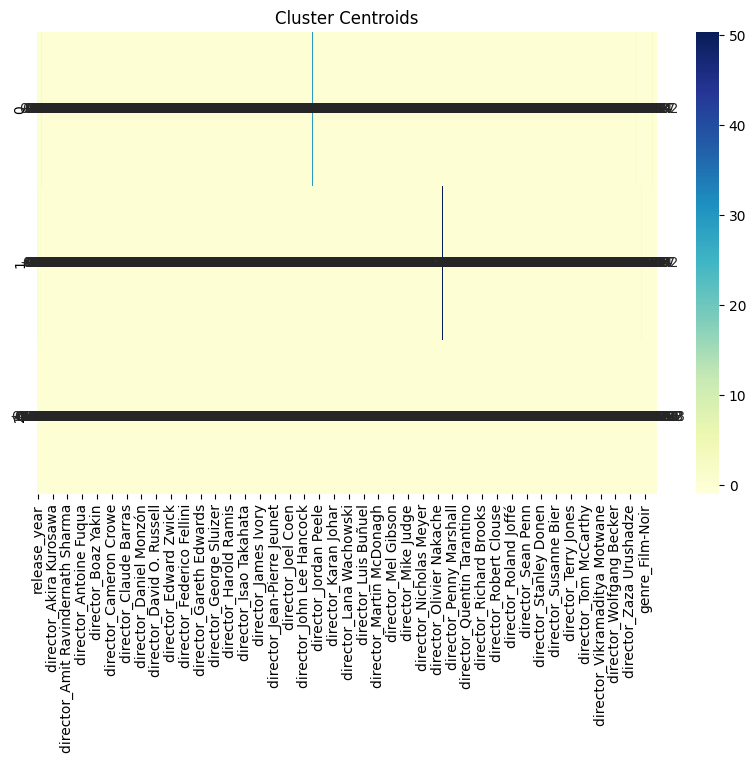

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert centroids to a DataFrame for easier plotting
centroid_df = pd.DataFrame(final_centroids, columns=data_scaled_df.columns)

# Plotting the centroids of each cluster
plt.figure(figsize=(10, 6))
sns.heatmap(centroid_df, cmap="YlGnBu", annot=True)
plt.title("Cluster Centroids")
plt.show()


**Feature Distribution in Clusters**

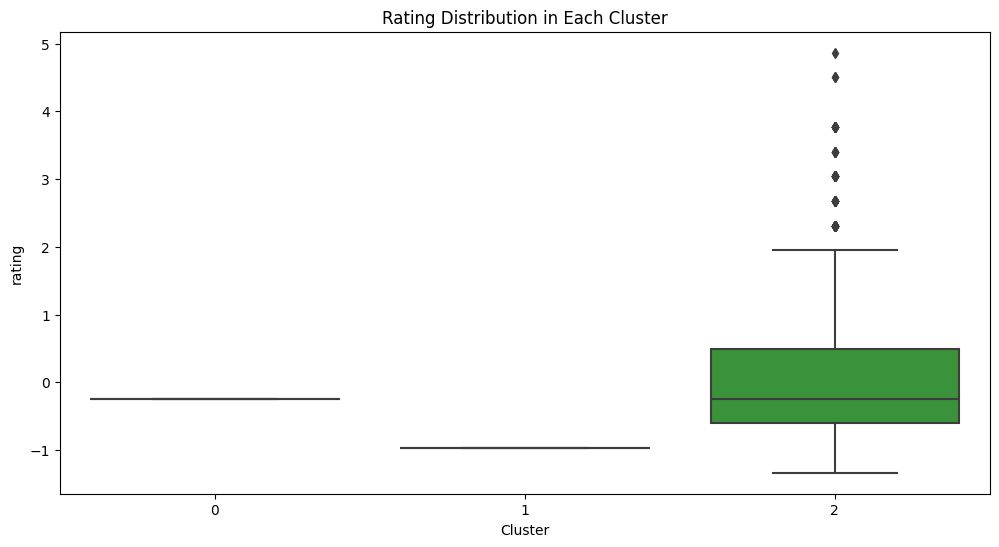

In [32]:
# Adding a new column to the original DataFrame for cluster assignments
data_scaled_df['Cluster'] = final_clusters

# Visualizing the distribution of features in each cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='rating', data=data_scaled_df)
plt.title("Rating Distribution in Each Cluster")
plt.show()


**Dimensionality Reduction for Visualization**

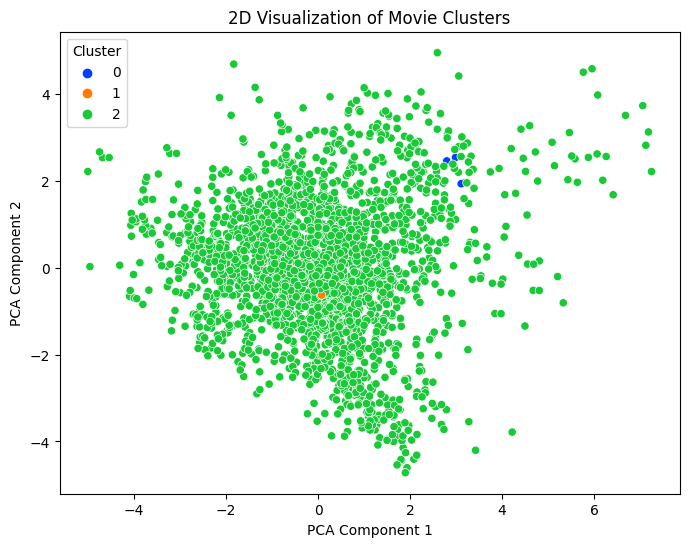

In [33]:
from sklearn.decomposition import PCA

# Reducing the data to 2 dimensions using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_scaled_df.drop('Cluster', axis=1))

# Plotting the reduced data with cluster assignments
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=final_clusters, palette='bright')
plt.title("2D Visualization of Movie Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()


<ipython-input-35-ee68f2c58396>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_analysis = data_with_clusters.groupby('Cluster').mean()


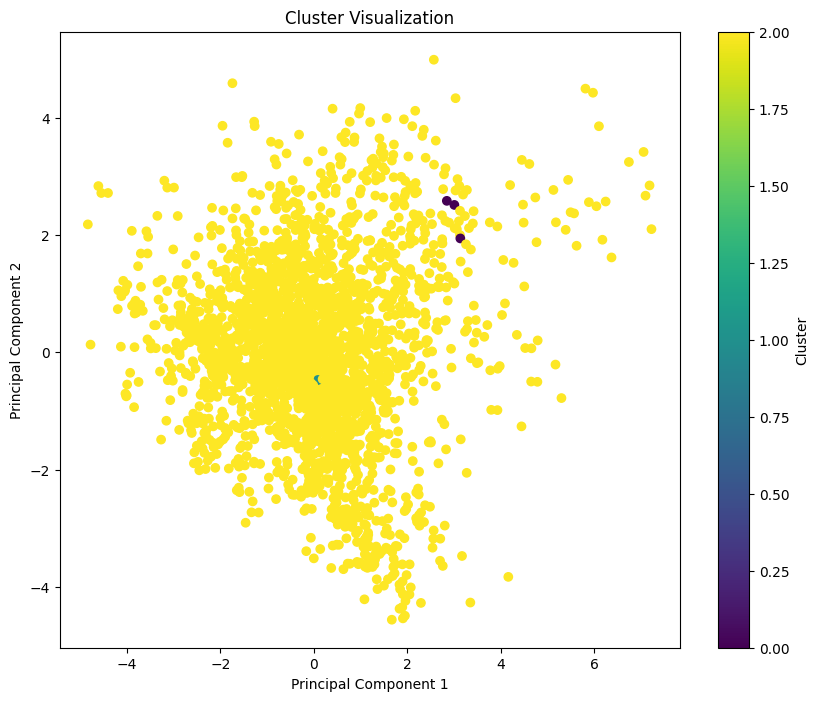

Movies recommended based on 'The Shawshank Redemption': ['The Game', 'South Park: Bigger, Longer & Uncut', 'His Girl Friday', 'Diabolique', 'M']


In [35]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Adding the cluster assignments to the original dataset
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = final_clusters

# Analyzing clusters by calculating mean values of features
cluster_analysis = data_with_clusters.groupby('Cluster').mean()

# Function to recommend movies from the same cluster
def recommend_movies(movie_title, n_recommendations=5):
    if movie_title not in data_with_clusters['title'].values:
        return "Movie not found in the dataset."
    cluster = data_with_clusters[data_with_clusters['title'] == movie_title]['Cluster'].values[0]
    recommendations = data_with_clusters[data_with_clusters['Cluster'] == cluster]['title'].sample(n_recommendations)
    return recommendations.tolist()

# Visualizing the clusters using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled_df)
plt.figure(figsize=(10, 8))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=final_clusters, cmap='viridis', marker='o')
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Example usage of the recommend_movies function
# Replace 'The Shawshank Redemption' with the movie of your choice
recommended_movies = recommend_movies('The Shawshank Redemption')
print("Movies recommended based on 'The Shawshank Redemption':", recommended_movies)


**Cluster Visualization:** The scatter plot visualizes the movie clusters in a 2-dimensional space, achieved using PCA. Each dot represents a movie, and its color indicates the cluster it belongs to.

**Cluster Analysis:** The mean values of features for each cluster are calculated. This table shows the average release_year, runtime, rating, metascore, and gross(M) for movies in each cluster, which helps understand the characteristics of each cluster.

**Movie Recommendations:** Based on the movie "The Shawshank Redemption", the following movies are recommended as they belong to the same cluster:

'The Others'

'Akira'

'Jab We Met'

'Zodiac'

'Drishyam'